### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy
plt.style.use('seaborn-v0_8')
%matplotlib inline

####Ignore warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

###Read data from CSV

In [3]:
csv_path = "/content/electricity_disturbance_data.csv"
df = pd.read_csv(csv_path)
df.head()

,Month,Area Affected,Event Type,Demand Loss (MW),Number of Customers Affected,Year,Datetime Event Began,Datetime of Restoration,Event Duration (hours)
0,January,Washington,System Operations,0.0,NaN,2019,2019-01-05 13:19:00,2019-01-05 15:07:00,2.0
1,January,Washington,Severe Weather,230.0,230000.0,2019,2019-01-06 03:00:00,2019-01-09 07:00:00,76.0
2,January,California,Severe Weather,300.0,90382.0,2019,2019-01-06 17:56:00,2019-01-06 21:52:00,4.0
3,January,Washington,Severe Weather,NaN,230000.0,2019,2019-01-06 01:00:00,2019-01-06 12:00:00,11.0
4,January,Michigan,System Operations,0.0,0.0,2019,2019-01-07 20:57:00,2019-01-07 21:32:00,1.0


### Descriptive statistics

In [4]:
df.describe()

,Demand Loss (MW),Number of Customers Affected,Year,Event Duration (hours)
count,1280.000000,1.549000e+03,1769.000000,1497.000000
mean,360.218750,5.160717e+04,2021.074053,15.456246
std,3980.493501,1.526484e+05,1.353581,32.035777
min,0.000000,0.000000e+00,2019.000000,0.000000
25%,0.000000,0.000000e+00,2020.000000,1.000000
50%,0.000000,0.000000e+00,2021.000000,3.000000
75%,22.000000,5.415800e+04,2022.000000,14.000000
max,133200.000000,2.000000e+06,2023.000000,329.000000


#### To avoid the data from skewing the outliers are dropped by only keeping values lesser than 98th percentile.

In [5]:
demand = df['Demand Loss (MW)'].quantile(.98)
customer = df['Number of Customers Affected'].quantile(.98)
duration = df['Event Duration (hours)'].quantile(.98)

df = df[df["Demand Loss (MW)"]<demand]
df = df[df["Number of Customers Affected"]<customer]
df = df[df["Event Duration (hours)"]<duration]

In [6]:
df.describe()

,Demand Loss (MW),Number of Customers Affected,Year,Event Duration (hours)
count,1026.000000,1026.000000,1026.000000,1026.000000
mean,58.889864,12208.779727,2021.083821,7.864522
std,236.535017,38985.411890,1.381689,16.613135
min,0.000000,0.000000,2019.000000,0.000000
25%,0.000000,0.000000,2020.000000,0.000000
50%,0.000000,0.000000,2021.000000,1.000000
75%,3.000000,0.000000,2022.000000,6.000000
max,3189.000000,370000.000000,2023.000000,108.000000


###Histogram Plots

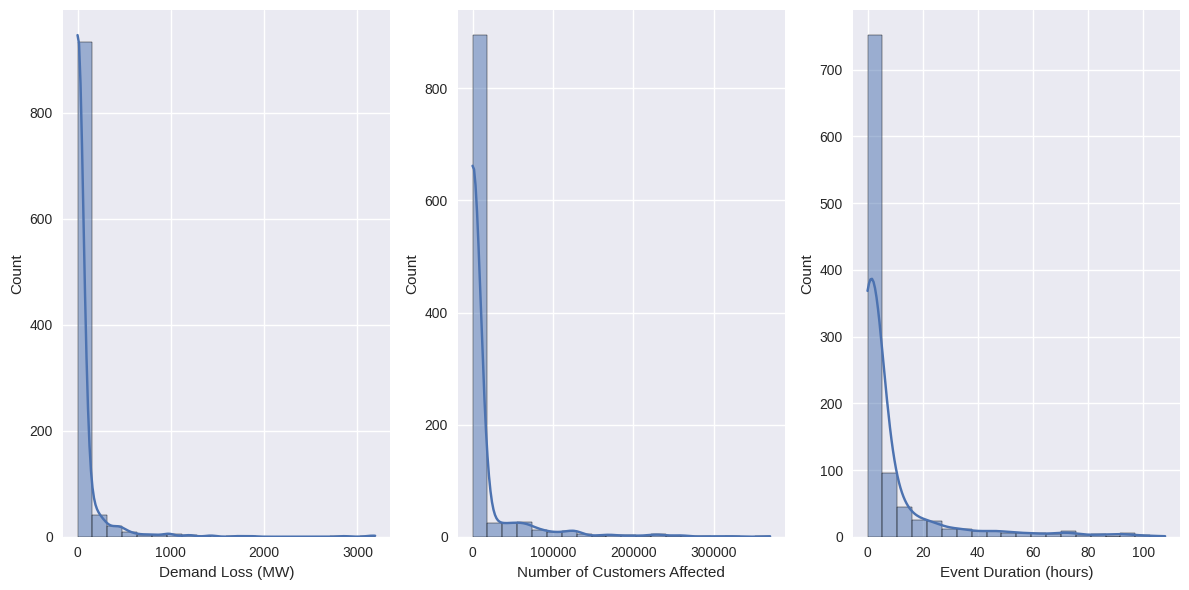

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.histplot(df['Demand Loss (MW)'].dropna(), bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel("Demand Loss (MW)")

sns.histplot(df['Number of Customers Affected'].dropna(), bins=20, kde=True, ax=axes[1])
axes[1].set_xlabel("Number of Customers Affected")

sns.histplot(df['Event Duration (hours)'].dropna(), bins=20, kde=True, ax=axes[2])
axes[2].set_xlabel("Event Duration (hours)")

plt.tight_layout()
plt.savefig('/content/Plots/histograms.png')
plt.show()


**General Observations:**

- **Skewness:** All three variables show a high degree of positive skewness, indicating that extreme values (high demand loss, many customers affected, and long event duration) are less frequent.

- **Central Tendency:** The central tendency (mean or median) for all three variables is likely to be low due to the skewness.
- **Variability:** There is a wide range in values for all three variables, suggesting a lot of variability in the impact of electrical disturbances.

### Correlation Heatmap

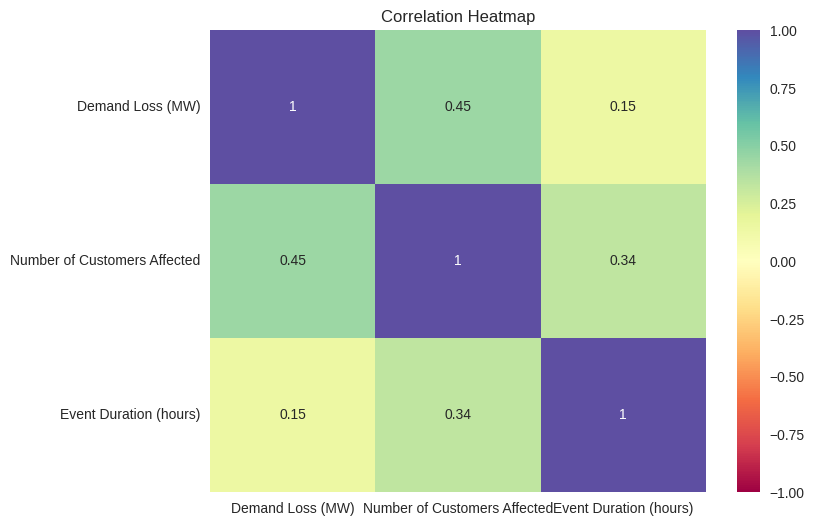

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Demand Loss (MW)','Number of Customers Affected','Event Duration (hours)']].corr(), annot=True, cmap='Spectral', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig('/content/Plots/correlation_heatmap.png')
plt.show()

####**Summary of Correlations:**

**Demand Loss (MW) and Number of Customers Affected:**

- **Correlation Coefficient:** 0.45
- **Interpretation:** There is a moderate positive correlation between demand loss (MW) and the number of customers affected. This suggests that as the demand loss increases, the number of customers affected tends to increase as well, but the **relationship is not very strong**.

**Number of Customers Affected and Event Duration (hours):**

- **Correlation Coefficient:** 0.34
- **Interpretation:** There is a moderate positive correlation between the number of customers affected and the event duration. This indicates that events affecting more customers tend to last longer, although the relationship is moderate and **other factors may also play a significant role**.

**Demand Loss (MW) and Event Duration (hours):**

- **Correlation Coefficient:** 0.15
- **Interpretation:** There is a weak positive correlation between demand loss (MW) and event duration. This suggests that the relationship between the amount of demand loss and the duration of the event is weak, implying that **factors other than the duration of the event are likely more significant** in determining the extent of demand loss.

### Filtering event types into unique_events_list

In [9]:
event_types=list(df['Event Type'].dropna().unique())

In [10]:
def get_unique_events(event_list,length=-1,):
    event_list_sorted = sorted(event_list, key=len)

    unique_events = []

    for event in event_list_sorted:
        modified_event = event
        if len(unique_events) == 0:
                unique_events.append(modified_event)
                continue
        for unique_event in unique_events:
            if unique_event in modified_event:
                modified_event = modified_event.replace(unique_event, '').strip()
        if modified_event not in unique_events and len(modified_event)>len(max(unique_events)):
            unique_events.append(modified_event)
    length_new = len(unique_events)
    if length != -1 and length_new == length:
        return unique_events
    else:
        return get_unique_events(unique_events,length_new)

In [11]:
unique_events_list = get_unique_events(event_types)
unique_events_list

['Other',
 'Sabotage',
 'Vandalism',
 'Cyber Event',
 'Severe Weather',
 'Physical Attack',
 'Natural Disaster',
 'System Operations',
 'Suspicious Activity',
 'Generation Inadequacy',
 'Fuel supply emergency',
 'Fuel Supply Deficiency',
 'Generator loss failure',
 'Transmission Interruption',
 'Distribution Interruption',
 'Transmission equipment failure',
 'Failure at high voltage substation switchyard']

# Questions

## Event and Impact Analysis

### What is the most common type of event?

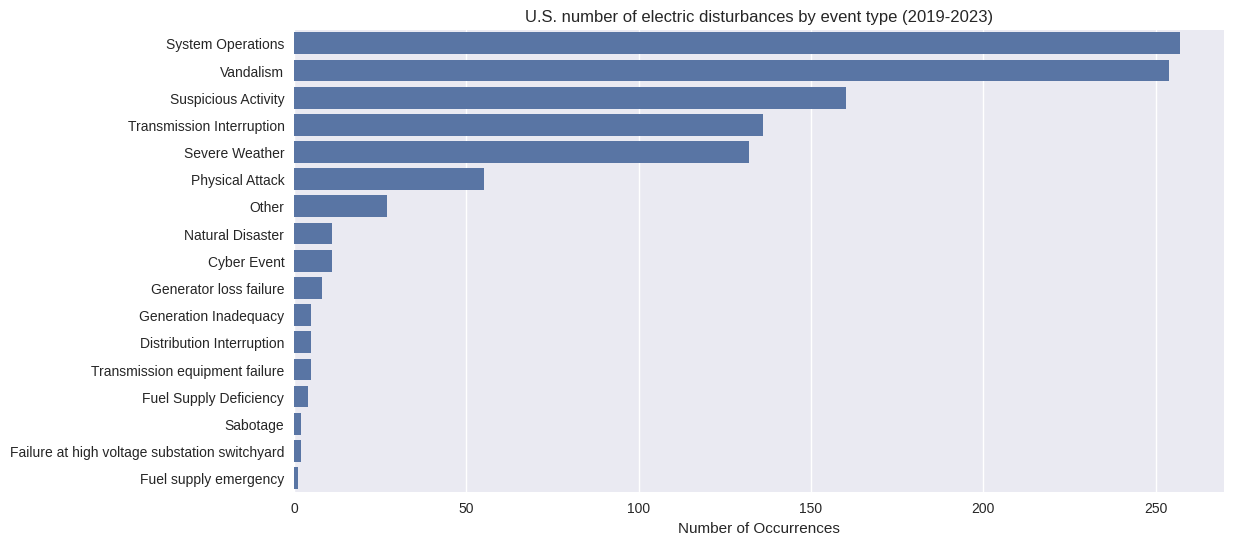

In [12]:
counts = []
for event in unique_events_list:
    counts.append(df['Event Type'][df['Event Type'].str.contains(event,case=False,regex=True)==True].count())

event_counts = pd.DataFrame({'Event Type': unique_events_list, 'Count': counts})
event_counts = event_counts.sort_values(by='Count', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(data=event_counts,x='Count',y='Event Type')
plt.title('U.S. number of electric disturbances by event type (2019-2023)')
plt.xlabel('Number of Occurrences')
plt.ylabel('')
plt.savefig('/content/Plots/event_frequency.png')
plt.show()


In [13]:
most_common_event = event_counts['Event Type'].iloc[0]
print(f"Most common type of event: {most_common_event}")

Most common type of event: System Operations


### Which areas are most affected by these events?

##### List of US States


In [14]:
states = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'District of Columbia':'DC'
}

location_to_state = {
    'Washington': ['WA'],
    'California': ['CA'],
    'Michigan': ['MI'],
    'New Mexico': ['NM'],
    'Montana': ['MT'],
    'Maine': ['ME'],
    'New Hampshire': ['NH'],
    'Pennsylvania': ['PA'],
    'Texas': ['TX'],
    'Colorado': ['CO'],
    'Ohio': ['OH'],
    'Utah': ['UT'],
    'Massachusetts': ['MA'],
    'Arkansas': ['AR'],
    'New Jersey': ['NJ'],
    'Wisconsin, Minnesota, Iowa, Illinois': ['WI', 'MN', 'IA', 'IL'],
    'Iowa': ['IA'],
    'South Carolina': ['SC'],
    'Oklahoma, Arkansas, Louisiana': ['OK', 'AR', 'LA'],
    'Oklahoma': ['OK'],
    'New York': ['NY'],
    'Virginia': ['VA'],
    'Oregon': ['OR'],
    'Minnesota': ['MN'],
    'Arizona': ['AZ'],
    'Alabama': ['AL'],
    'Indiana': ['IN'],
    'Kentucky': ['KY'],
    'North Dakota': ['ND'],
    'Nevada': ['NV'],
    'Idaho': ['ID'],
    'South Dakota': ['SD'],
    'Missouri': ['MO'],
    'Wisconsin': ['WI'],
    'Nebraska': ['NE'],
    'District of Columbia': ['DC'],
    'Louisiana': ['LA'],
    'Maryland': ['MD'],
    'North Carolina': ['NC'],
    'Wyoming': ['WY'],
    'Tennessee': ['TN'],
    'Kansas': ['KS'],
    'Illinois': ['IL'],
    'Florida': ['FL'],
    'Mississippi': ['MS'],
    'Connecticut': ['CT'],
    'Delaware': ['DE'],
    'Georgia': ['GA'],
    'West Virginia': ['WV'],
    'Vermont': ['VT'],
    'Rhode Island': ['RI'],
    'Washington, Idaho, Montana': ['WA', 'ID', 'MT'],
    'Pacificorp': ['CA', 'OR', 'WA', 'WY', 'UT'],
    'Tampa Electric Company': ['FL'],
    'Seminole Electric Cooperative Inc': ['FL'],
    'GenOn Energy – New Castle Power LLC': ['PA'],
    'Orsted Americas': ['NJ'],
    'New York State Electric & Gas': ['NY'],
    'WEC Energy Group (WEPCO, WPSC, UMERC, WEP-MIUP)': ['WI', 'MI'],
    'Apex Generating Station': ['MT'],
    'Bonneville Power Administration': ['WA', 'OR', 'ID', 'MT'],
    'Austin Energy': ['TX'],
    'Oncor Electric Delivery Company LLC': ['TX'],
    'Western Area Power Administration - Upper Great Plains Region - (NCR01036)': ['MT', 'ND', 'SD', 'NE', 'IA', 'MN'],
    'LUMA Energy': ['PR'],
    'First Energy Solutions Corp.': ['OH', 'PA', 'WV'],
    'NV Energy': ['NV'],
    'Consolidated Edison of New York, Inc.': ['NY'],
    'Otter Tail Power Co': ['MN', 'ND', 'SD'],
    'Lower Colorado River Authority': ['TX']
}

#### Filter and map states with codes

In [15]:
num_of_customer_affected = {}
num_of_events = []
average_demand_loss = []
for state,code  in states.items():
    num_of_customer_affected[code] = 0
    possible_locations = []
    for loc, codes in location_to_state.items():
        if code in codes:
            possible_locations.append(loc)
    locs = []
    dloss = []
    for location in possible_locations:
        num_of_customer_affected[code]+=df['Number of Customers Affected'][df['Area Affected'].str.contains(location,case=False,regex=True)==True].sum()
        locs.append(df['Year'][df['Area Affected'].str.contains(location,case=False,regex=True)==True].count())
        dloss.append(df['Demand Loss (MW)'][df['Area Affected'].str.contains(location,case=False,regex=True)==True].mean())
    if dloss:
        x=round(sum(dloss)/len(dloss),2)
        if np.isnan(x):
            x=0.
        average_demand_loss.append(x)
    else:
        average_demand_loss.append(0)
    num_of_events.append(sum(locs))

In [16]:
df_num_of_customer_affected = pd.DataFrame.from_dict(num_of_customer_affected, orient='index', columns=['Number of Customers Affected'])
df_num_of_customer_affected.reset_index(inplace=True)
df_num_of_customer_affected.rename(columns={'index': 'code'}, inplace=True)
df_num_of_customer_affected["state"] = list(states.keys())
df_num_of_customer_affected["Number of Events"] = num_of_events
df_num_of_customer_affected["Average Demand Loss (MW)"] = average_demand_loss

#### US Map plot with deatils about
- Number of customers affected
- Average Demand Loss (MW)
- Number of Events

In [17]:
fig = px.choropleth(df_num_of_customer_affected,
    locations='code',
    color='Number of Events',
    locationmode='USA-states',
    labels={'color': 'Number of Events'},
    color_continuous_scale='dense',
    hover_name='state',
    hover_data=['Number of Customers Affected','Average Demand Loss (MW)'],
    scope='usa'
)
fig.update_layout(
    title='US Electric Disturbances (2019-2023)',
    geo=dict(showframe=False, projection={'type': 'albers usa'}),
)
fig.write_html('/content/Plots/US_map_interactive.html')
fig.show()


###What is the average duration of each event type?

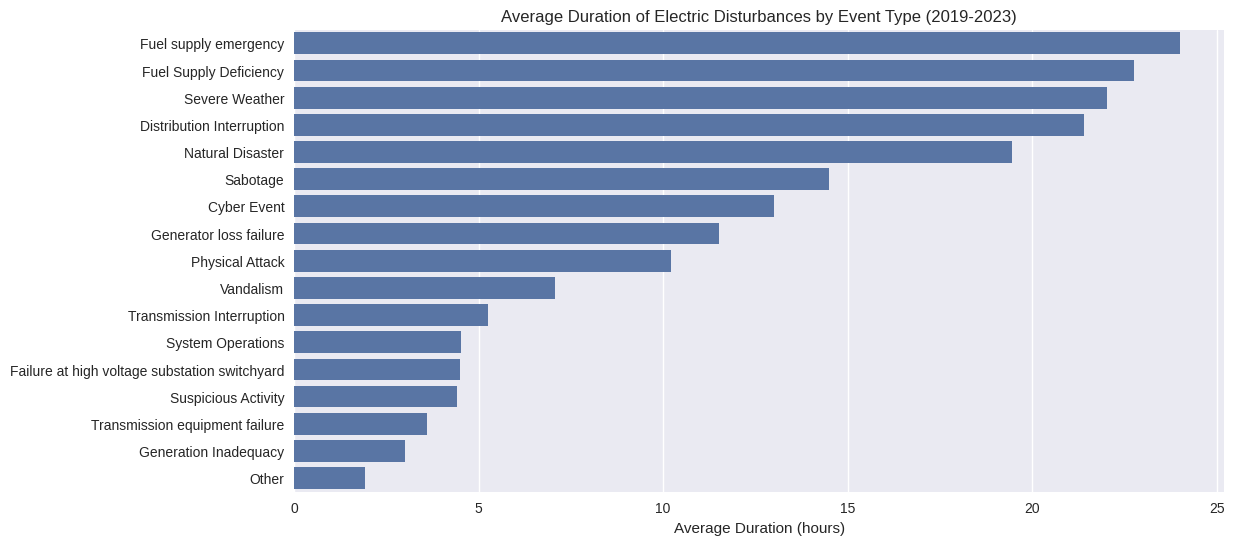

In [18]:
average_duration = {}
for event in unique_events_list:
  average_duration[event] = df['Event Duration (hours)'][df['Event Type'].str.contains(event,case=False,regex=True)==True].mean()

average_duration_df = pd.DataFrame.from_dict(average_duration, orient='index', columns=['Average Duration (hours)'])
average_duration_df.sort_values(by='Average Duration (hours)',ascending=False,inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=average_duration_df,x='Average Duration (hours)',y=average_duration_df.index)
plt.title('Average Duration of Electric Disturbances by Event Type (2019-2023)')
plt.xlabel('Average Duration (hours)')
plt.ylabel('')
plt.savefig('/content/Plots/average_duration_barplot.png')
plt.show()


**Observation**
- Fuel type emergencies on average take longer time to restore the power.

##Demand and Customer Impact

###Which Events have greater average of Demand Loss (MW)?

In [19]:
average_demand_loss = {}

for event in unique_events_list:
  average_demand_loss[event] = df['Demand Loss (MW)'][df['Event Type'].str.contains(event,case=False,regex=True)==True].mean()

demand_loss_df = pd.DataFrame.from_dict(average_duration, orient='index', columns=['Demand Loss (MW)'])
demand_loss_df.sort_values(by='Demand Loss (MW)',ascending=False,inplace=True)

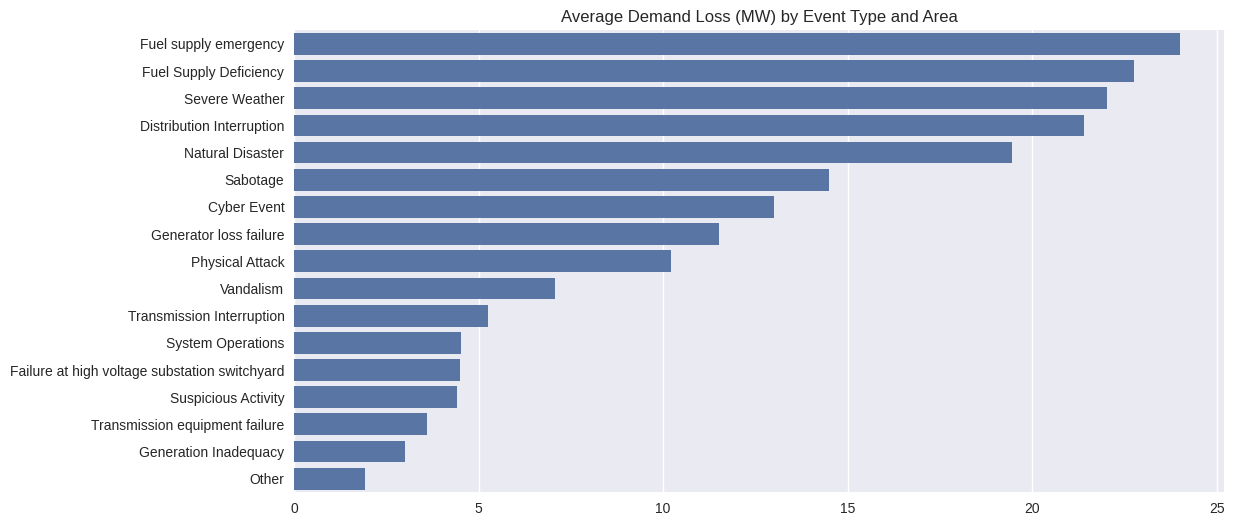

In [20]:
plt.figure(figsize=(12, 6))
sns.barplot(demand_loss_df,x='Demand Loss (MW)',y=demand_loss_df.index)
plt.title('Average Demand Loss (MW) by Event Type and Area')
plt.xlabel('')
plt.ylabel('')
plt.savefig('/content/Plots/average_demand_loss_barplot.png')
plt.show()

**Observation**
- Fuel type emergencies have a high average Demand loss (MW).

###How many customers are affected by different types of events?

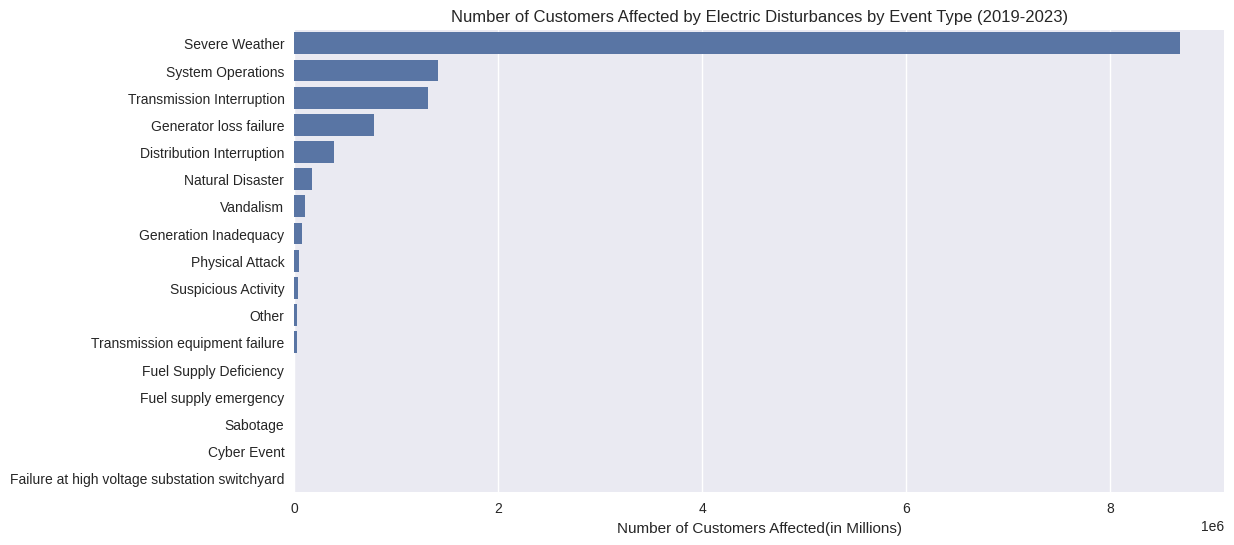

In [21]:
num_of_customer_affected = {}

for event in unique_events_list:
  num_of_customer_affected[event] = df['Number of Customers Affected'][df['Event Type'].str.contains(event,case=False,regex=True)==True].sum()

num_of_customer_affected_df = pd.DataFrame.from_dict(num_of_customer_affected, orient='index', columns=['Number of Customers Affected'])
num_of_customer_affected_df.sort_values(by='Number of Customers Affected',ascending=False,inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=num_of_customer_affected_df,x='Number of Customers Affected',y=num_of_customer_affected_df.index)
plt.title('Number of Customers Affected by Electric Disturbances by Event Type (2019-2023)')
plt.xlabel('Number of Customers Affected(in Millions)')
plt.ylabel('')
plt.savefig('/content/Plots/num_of_customer_affected_barplot.png')
plt.show()


**Observation**
- A large population of people is affeted by Severe weather/weather type events.

##Temporal Analysis

###Are there specific months with higher frequencies of events?

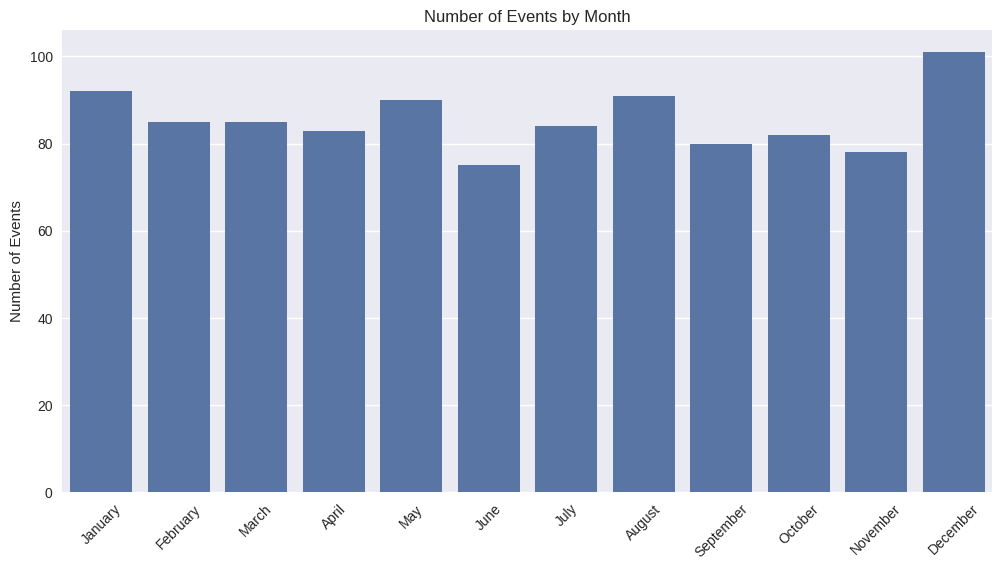

In [26]:
event_counts_by_month = df.groupby('Month')['Year'].count().reindex(df['Month'].unique())

plt.figure(figsize=(12, 6))
sns.barplot(x=event_counts_by_month.index, y=event_counts_by_month.values)
plt.title('Number of Events by Month')
plt.xlabel('')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.savefig('/content/Plots/event_counts_by_month.png')
plt.show()

**Observation**
- The number of events over different months remains almost the same with small vatiations.

### Is there a trend in the number of events over the years?

Trend line: y = 0.09x + 14.90
R-squared: 0.08
P-value: 0.03
Standard error: 0.04


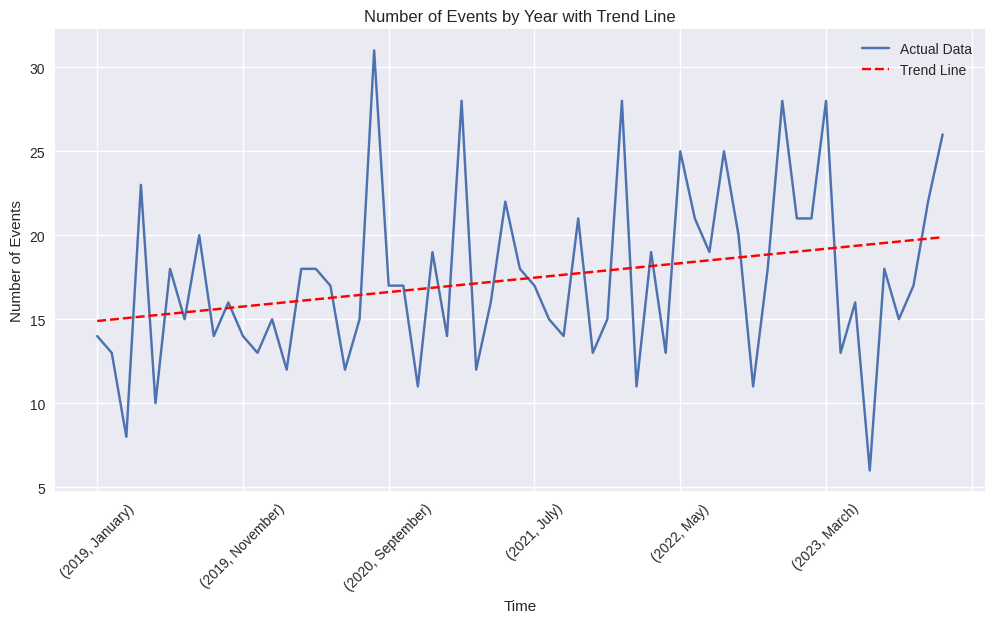

In [23]:
event_counts_by_year = df.groupby(['Year','Month'])['Year'].count().unstack()
event_counts_by_year = event_counts_by_year[df['Month'].unique()].stack() #The columns are unstacked and stacked to sort months in chronological order

# Create a comparison plot with the trend line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    range(len(event_counts_by_year)), event_counts_by_year.values)

# Print the trend line equation and R-squared value
print(f'Trend line: y = {slope:.2f}x + {intercept:.2f}')
print(f'R-squared: {r_value**2:.2f}')
print(f'P-value: {p_value:.2f}')
print(f'Standard error: {std_err:.2f}')

# Plot the data and the trend line
plt.figure(figsize=(12, 6))
event_counts_by_year.plot(kind='line',label='Actual Data')
plt.plot(range(len(event_counts_by_year)),
         slope * range(len(event_counts_by_year)) + intercept,
         color='red', linestyle='--', label='Trend Line')
plt.title('Number of Events by Year with Trend Line')
plt.xlabel('Time')
plt.ylabel('Number of Events')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('/content/Plots/event_counts_by_year_with_trend.png')
plt.show()


**Interpretation:**
- The linear trend line y = 0.08x + 15.05 indicates a weak positive relationship between x and y, as the slope is small (0.08).
- The R-squared value of 0.06 shows that this model explains only 6% of the variability in y, implying that other factors might be influencing y.
- The p-value of 0.05 suggests that the relationship between x and y is on the threshold of statistical significance.
- The standard error of 0.04 suggests that the slope estimate is relatively precise, though the overall fit of the model is weak.

In summary, the data suggests that while there is a relationship between Number of Events and Time , it is not strong, and most of the variation in
Number of Events is due to factors other than Time.

### How does the event duration vary over different months?

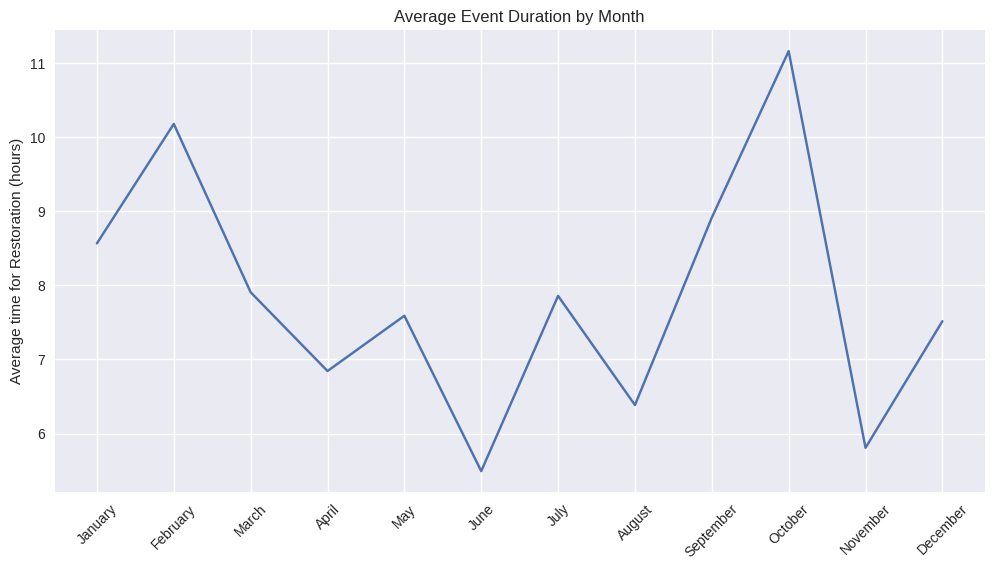

In [24]:
average_duration = df.groupby('Month')['Event Duration (hours)'].mean().reindex(df['Month'].unique())

plt.figure(figsize=(12, 6))
sns.lineplot(x=average_duration.index, y=average_duration.values)
plt.title('Average Event Duration by Month')
plt.xlabel('')
plt.ylabel('Average time for Restoration (hours)')
plt.xticks(rotation=45)
plt.savefig('/content/Plots/average_duration_by_month.png')
plt.show()


**Observation:** The graph shows a peak during the month of october.

**Interpretation:** The data suggests that weather plays a significant role in restoration times.

